In [29]:
library(dplyr)
library(randomForest)
library(pROC)
library(caret)
library(geosphere)
library(readr)
library(sf)
library(ggplot2)
library(tidyr)

In [30]:
trajectoires <- read_csv("trajectoires_drones_only_within_polygon.csv")
caracteristiques <- read_csv("caracteristique_drone.csv")

New names:
• `` -> `...1`
Rows: 106095 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Drone_ID, Drone_Type, Origine, Segment, Nom
dbl (8): ...1, Iteration, Vitesse, Altitude, Distance_Cumulee, Temps_Ecoule,...
lgl (1): within_updated

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Nom, Origine, Type
dbl (6): Altitudemax, Vitessemax, Portee(km), Altitudemin, Cruisespeed, Port...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Calcul de la distance entre le premier point répertorié et la frontière

In [31]:
# Convertir les données en objet sf avec les colonnes de longitude et latitude
trajectoires_sf <- st_as_sf(trajectoires, coords = c("long", "lat"), crs = 4326)

# Définir toutes les lignes de front comme déjà fait dans votre code
line_front_1 <- st_linestring(matrix(c(38.45637663250045, 48.532826797664846,
                                       37.7658438650635, 50.07933496745732), ncol = 2, byrow = TRUE))
line_front_2 <- st_linestring(matrix(c(32.1672572599026, 46.434198799864376,
                                       38.45637663250045, 48.532826797664846), ncol = 2, byrow = TRUE))
line_front_3 <- st_linestring(matrix(c(37.7658438650635, 50.07933496745732,
                                       34.73281464092588, 50.92405887999426), ncol = 2, byrow = TRUE))
line_front_4 <- st_linestring(matrix(c(34.73281464092588, 50.92405887999426,
                                       33.2228480040779, 52.2874298771795), ncol = 2, byrow = TRUE))
line_front_5 <- st_linestring(matrix(c(33.2228480040779, 52.2874298771795,
                                       28.681296931138895, 51.36480437280772), ncol = 2, byrow = TRUE))
line_front_6 <- st_linestring(matrix(c(28.681296931138895, 51.36480437280772,
                                       23.804251089502966, 51.633903542920415), ncol = 2, byrow = TRUE))
line_front_7 <- st_linestring(matrix(c(23.804251089502966, 51.633903542920415,
                                       22.427459199975896, 48.35732598510753), ncol = 2, byrow = TRUE))
line_front_8 <- st_linestring(matrix(c(22.427459199975896, 48.35732598510753,
                                       29.422670952108504, 48.078730771810925), ncol = 2, byrow = TRUE))
line_front_9 <- st_linestring(matrix(c(29.422670952108504, 48.078730771810925,
                                       28.414621049701758, 45.30127917139041), ncol = 2, byrow = TRUE))

In [32]:
# Combiner les lignes de front en un objet sf
front_lines <- st_sfc(list(line_front_1, line_front_2, line_front_3, line_front_4, line_front_5, 
                           line_front_6, line_front_7, line_front_8, line_front_9), crs = 4326)

# Fermer les lignes de front en un polygone
all_lines <- st_union(front_lines)

# Convertir en POLYGON si possible
front_polygon <- st_cast(all_lines, "POLYGON")

# Vérifier si chaque point est à l'intérieur du polygone
trajectoires_sf <- trajectoires_sf %>%
  mutate(within = st_within(trajectoires_sf, front_polygon, sparse = FALSE)) %>%
  mutate(within = as.logical(within))  # Convertir la colonne en TRUE/FALSE

# Convertir le résultat en data.frame pour le sauvegarder
trajectoires_result <- as.data.frame(trajectoires_sf)


In [33]:
# Extraire la bordure du polygone (bordure = "boundary")
front_polygon_border <- st_cast(front_polygon, "MULTILINESTRING")

# Définir une distance seuil pour "proche de la bordure" (en mètres)
distance_seuil <- 10000 

Création des features pour notre RandomForest

In [34]:
# Calculer la distance du premier point à la bordure
trajectoires_resume <- trajectoires %>%
  group_by(Drone_ID) %>%
  summarise(
    First_Point = first(st_sfc(st_point(c(first(long), first(lat))), crs = 4326)),
    Distance_Bordure = as.numeric(st_distance(First_Point, front_polygon_border, by_element = TRUE)),
    Direction_Ukraine = ifelse(first(long) > nth(long, 2), 1, 0),
    Changement_Direction = ifelse(var(long, na.rm = TRUE) > 0.1 | var(lat, na.rm = TRUE) > 0.1, 1, 0),
    Premiere_Appearance = ifelse(Distance_Bordure <= distance_seuil, 1, 0), 
    Origine = first(Origine),
    Type = first(Drone_Type),
    Vitesse = mean(Vitesse[1:5], na.rm = TRUE),
    Altitude = mean(Altitude[1:5], na.rm = TRUE)
  )

# Joindre les caractéristiques des drones
resultat_final <- trajectoires_resume %>%
  left_join(caracteristiques, by = c("Origine" = "Origine", "Type" = "Type"))
  #rename Origine en 1 si russe et en 0 si Ukrainien
  resultat_final$Origine <- ifelse(resultat_final$Origine == "Russe", 1, 0)
  resultat_final$Type <- ifelse(resultat_final$Type == "Suicide", 1, 0)

Resultat de la classification

In [35]:
# Sélectionner uniquement les caractéristiques autorisées et les cibles
features <- c("Distance_Bordure", "Direction_Ukraine", "Changement_Direction", "Vitesse", "Altitude")
target_origin <- "Origine"

# Vérification des valeurs manquantes et imputation
resultat_final <- resultat_final %>% mutate(across(all_of(features), ~ ifelse(is.na(.), median(., na.rm = TRUE), .)))

# Division des données en ensembles d'entraînement et de test (80/20)
set.seed(42)
trainIndex <- createDataPartition(resultat_final$Origine, p = 0.8, list = FALSE)
train_data <- resultat_final[trainIndex, ]
test_data <- resultat_final[-trainIndex, ]

# Entraîner un modèle Random Forest pour prédire l'origine
rf_origin <- randomForest(as.factor(Origine) ~ ., 
              data = train_data[, c(features, target_origin)],
              ntree = 100, importance = TRUE)

# Prédire pour Origine
pred_origin <- predict(rf_origin, newdata = test_data)

# Évaluation du modèle pour Origine
cat("### Évaluation du modèle pour Origine ###\n")
print(confusionMatrix(as.factor(pred_origin), as.factor(test_data$Origine)))

# Importance des variables
cat("\n### Importance des variables pour Origine ###\n")
importance_values <- importance(rf_origin)
print(importance_values)

# Enregistrer dans un dataframe l'output du random forest, les données sur l'importance de chaque variable afin de produire un graphique
output_origin <- data.frame(
  Variable = rownames(importance_values),
  ImportanceUkraine = importance_values[, "0"],
  ImportanceRusse = importance_values[, "1"]
)


### Évaluation du modèle pour Origine ###
Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  89   0
         1   0 110
                                     
               Accuracy : 1          
                 95% CI : (0.9816, 1)
    No Information Rate : 0.5528     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.4472     
         Detection Rate : 0.4472     
   Detection Prevalence : 0.4472     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : 0          
                                     

### Importance des variables pour Origine ###
   

In [36]:
target_type <- "Type"

# Entraîner un modèle Random Forest pour prédire le Type
rf_type <- randomForest(as.factor(Type) ~ ., 
            data = train_data[, c(features, target_type)],
            ntree = 100, importance = TRUE)

# Prédire pour Type
pred_type <- predict(rf_type, newdata = test_data)

# Évaluation du modèle pour Type
cat("\n### Évaluation du modèle pour Type ###\n")
print(confusionMatrix(as.factor(pred_type), as.factor(test_data$Type)))

# Importance des variables
cat("\n### Importance des variables pour Type ###\n")
importance_values_type <- importance(rf_type)
print(importance_values_type)

# Enregistrer dans un dataframe l'output du random forest, les données sur l'importance de chaque variable afin de produire un graphique
output_type <- data.frame(
  Variable = rownames(importance_values_type),
  ImportanceUkraine = importance_values_type[, "0"],
  ImportanceRusse = importance_values_type[, "1"]
)


### Évaluation du modèle pour Type ###
Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 100   0
         1   0  99
                                     
               Accuracy : 1          
                 95% CI : (0.9816, 1)
    No Information Rate : 0.5025     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.5025     
         Detection Rate : 0.5025     
   Detection Prevalence : 0.5025     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : 0          
                                     

### Importance des variables pour Type ###
        

Graphique

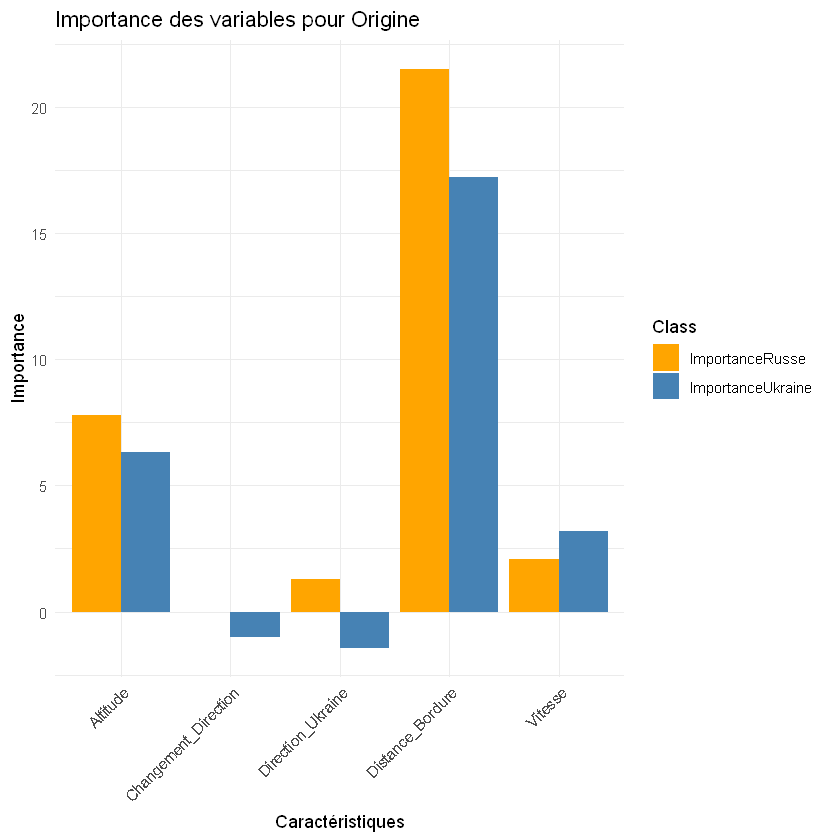

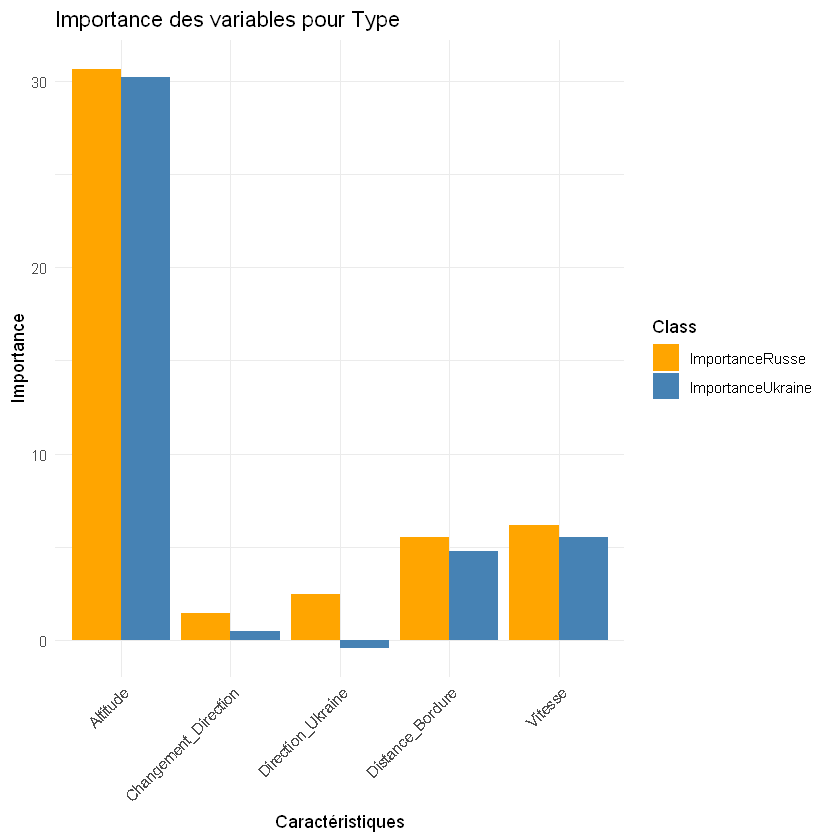

In [37]:
# Transformation des données pour ggplot
output_origin_long <- pivot_longer(output_origin, cols = c("ImportanceUkraine", "ImportanceRusse"), 
                   names_to = "Class", 
                   values_to = "Importance")

output_type_long <- pivot_longer(output_type, cols = c("ImportanceUkraine", "ImportanceRusse"), 
                 names_to = "Class", 
                 values_to = "Importance")

# Graphique pour Origine
ggplot(output_origin_long, aes(x = Variable, y = Importance, fill = Class)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(
  title = "Importance des variables pour Origine",
  x = "Caractéristiques",
  y = "Importance"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_fill_manual(values = c("ImportanceUkraine" = "steelblue", "ImportanceRusse" = "orange"))

# Graphique pour Type
ggplot(output_type_long, aes(x = Variable, y = Importance, fill = Class)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(
  title = "Importance des variables pour Type",
  x = "Caractéristiques",
  y = "Importance"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_fill_manual(values = c("ImportanceUkraine" = "steelblue", "ImportanceRusse" = "orange"))
